<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

## Introduction to Pandas Grouping


---

### Learning Objectives
*After this lesson, you will be able to:*
- Know what situations **grouping** is useful for
- Explain and use the **`.groupby()`** function in Pandas
- Demonstrate aggregation and plotting methods by groups in Pandas

### Lesson Guide

- [Overview of multi-dimensional data analysis](#overview)
- [Examples of when to group data](#grouping_examples)
- [Load the Titanic dataset](#load_titanic)
- [Introduction to pandas `.groupby()`](#groupby)
- [Grouping by multiple variables](#groupby_multiple)
- [Applying basic functions to groups](#basic_functions)
- [Removing the hierarchical index](#removing_hierarchical)
- [Applying custom functions with apply](#custom_functions)
- [Plotting basic histograms with groups](#basic_plotting)
- [Grouped histograms](#grouped_hists)
- [Independent practice](#independent_practice)


<a id='overview'></a>

### Overview of multi-dimensional data analysis

---

- Describe segments of your data based on unique values
- Understand characteristics of your data
   - Summary statistics across subsets
   - Discover patterns that exist in some subsets but not others
- Finding duplicate values or redundant data
- Apply aggregate functions to subsets


<a id='grouping_examples'></a>

### Analyzing data by group: some specific examples

---

 - Sum of crimes by time of day in SF (morning, afternoon, night)
 - Count number of people with the same last name
 - Median number of multi-unit buildings in a region
 - Popularity of movie genres by region
 - Segmenting customers based on age, buying habbits, interests, behavior
 - Using the "GROUP BY" clause in a database query using SQL

#### Subset aggregation:

This chart stratifies a single variable "Industry", **counting** job openings within category.

![](http://www.rasmussen.edu/images/blogs/1360270834-402_Graphs_JobOpeningsByIndustry.jpg)

#### Hierarchical aggregation

This chart aggregates first by a top level group, "industry", and then a secondary group "date" within each industry.

![](http://junkcharts.typepad.com/.a/6a00d8341e992c53ef0192acc65090970d-pi)

<a id='load_titanic'></a>

### Exploring the Titanic dataset with grouping

---

To explore the power of grouping with pandas we will be using [the famous Titanic dataset that can be downloaded from Kaggle](https://www.kaggle.com/c/titanic). From the competition decription:

>The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

>One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

Though we will not be doing any modeling of survival rates in this lesson, there are interesting patterns to be found just by exploring descriptive statistics in cross-sections of the data.

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

%matplotlib inline
%config InlineBackend.figure_format ='retina'

**Load the data into pandas.**

In [11]:
path_to_file = 'datasets/titanic_clean.csv'
titanic=pd.read_csv(path_to_file)

In [12]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


The data contains a variety of information about passengers involved in the sinking of the Titanic.

**Perform the initial EDA steps that you should consider whenever you load data into a dataframe.**

In [13]:
titanic.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Embarked        object
dtype: object

In [14]:
titanic.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

In [15]:
titanic.shape

(712, 10)

In [16]:
titanic['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [17]:
titanic['Embarked'].value_counts()

S    554
C    130
Q     28
Name: Embarked, dtype: int64

In [18]:
titanic['Pclass'].value_counts()

3    355
1    184
2    173
Name: Pclass, dtype: int64

In [19]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,448.589888,0.404494,2.240169,29.642093,0.514045,0.432584,34.567251
std,258.683191,0.491139,0.836854,14.492933,0.930692,0.854181,52.938648
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.750000,0.000000,1.000000,20.000000,0.000000,0.000000,8.050000
50%,445.000000,0.000000,2.000000,28.000000,0.000000,0.000000,15.645850
75%,677.250000,1.000000,3.000000,38.000000,1.000000,1.000000,33.000000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


<a id='groupby'></a>

### Intro to `.groupby()` in pandas

---

The built-in `.groupby()` functions for dataframes is one of the most useful tools in pandas. As the name implies, `.groupby` will group your dataset by one or more user-specified column names.

**Using `.groupby`, create a grouped dataframe where the titanic dataset is grouped by "Pclass".**

In [20]:
grouped_by_classes=titanic.groupby('Pclass')

In [21]:
grouped_by_classes

**Print out the type of the grouped dataframe.**

In [22]:
type(grouped_by_classes)

pandas.core.groupby.DataFrameGroupBy

Instead of a `DataFrame` object we now have a `DataFrameGroupBy` object. This operates somewhat differently than the DataFrame we are used to, as we shall see.

**Try pulling out the first group from the grouped dataframe with index 0.**

In [23]:
grouped_by_classes[0]

KeyError: 'Column not found: 0'

Grouped dataframes do not work the same as python lists. You can't pull out the different groups with indexers. Despite this, grouped dataframe objects **are** iterable! You can step through them using a for-loop, for example.

In our grouped dataframe, each element will be a tuple containing the Pclass group as its first element, and the subset of the original titanic dataframe for that Pclass as its second element.

**Write a for-loop to iterate through the grouped dataframe, printing out the PClass and the header of the subset each time.**

In [20]:
for class_tuple in grouped_by_classes:
    print(class_tuple[0])
    print(class_tuple[1].head(),'\n-----------------\n')

1
    PassengerId  Survived  Pclass  \
1             2         1       1   
3             4         1       1   
5             7         0       1   
10           12         1       1   
20           24         1       1   

                                                 Name     Sex   Age  SibSp  \
1   Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
3        Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
5                             McCarthy, Mr. Timothy J    male  54.0      0   
10                           Bonnell, Miss. Elizabeth  female  58.0      0   
20                       Sloper, Mr. William Thompson    male  28.0      0   

    Parch     Fare Embarked  
1       0  71.2833        C  
3       0  53.1000        S  
5       0  51.8625        S  
10      0  26.5500        S  
20      0  35.5000        S   
-----------------

2
    PassengerId  Survived  Pclass                                 Name  \
8            10         1     

In [21]:
for class_tuple in grouped_by_classes:
    print(class_tuple[0])
    print(class_tuple[1].head()[['Pclass','Fare']],'\n-----------------\n')

1
    Pclass     Fare
1        1  71.2833
3        1  53.1000
5        1  51.8625
10       1  26.5500
20       1  35.5000 
-----------------

2
    Pclass     Fare
8        2  30.0708
14       2  16.0000
17       2  26.0000
18       2  13.0000
25       2  10.5000 
-----------------

3
   Pclass     Fare
0       3   7.2500
2       3   7.9250
4       3   8.0500
6       3  21.0750
7       3  11.1333 
-----------------



In [22]:
len(grouped_by_classes)

3

In [23]:
for class_tuple in grouped_by_classes:
    print(type(class_tuple[0]))
    print(type(class_tuple[1]))

<class 'int'>
<class 'pandas.core.frame.DataFrame'>
<class 'int'>
<class 'pandas.core.frame.DataFrame'>
<class 'int'>
<class 'pandas.core.frame.DataFrame'>


In [24]:
for class_group, df in grouped_by_classes:
    print(type(class_group))
    print(type(df))

<class 'int'>
<class 'pandas.core.frame.DataFrame'>
<class 'int'>
<class 'pandas.core.frame.DataFrame'>
<class 'int'>
<class 'pandas.core.frame.DataFrame'>


<a id='groupby_multiple'></a>

### Grouping by multiple fields

---

Grouping by more than one column is simple. The `.groupby()` function can take a list of column names to group by. When you group by more than one column, each subset of the data will correspond to one of the distinct combinations of the grouping columns.

**Create a grouped dataframe by grouping the titanic data by "Pclass" and "Survived".**

In [25]:
newgrouped=titanic.groupby(['Pclass','Survived'])

**Print out the length of this grouped dataframe.**

It is the same length as unique combinations of Pclass and Survied: 3 Pclasses by 2 Survival values.

In [26]:
len(newgrouped)

6

In [27]:
for group, df in newgrouped:
    print(group)
    print(df.head()[['Fare','Survived']],'\n----------------\n')

(1, 0)
        Fare  Survived
5    51.8625         0
23  263.0000         0
24   27.7208         0
26   82.1708         0
27   52.0000         0 
----------------

(1, 1)
       Fare  Survived
1   71.2833         1
3   53.1000         1
10  26.5500         1
20  35.5000         1
38  76.7292         1 
----------------

(2, 0)
    Fare  Survived
17  26.0         0
25  10.5         0
32  21.0         0
52  10.5         0
54  73.5         0 
----------------

(2, 1)
       Fare  Survived
8   30.0708         1
14  16.0000         1
18  13.0000         1
33  41.5792         1
39  26.0000         1 
----------------

(3, 0)
      Fare  Survived
0    7.250         0
4    8.050         0
6   21.075         0
11   8.050         0
12  31.275         0 
----------------

(3, 1)
       Fare  Survived
2    7.9250         1
7   11.1333         1
9   16.7000         1
19   8.0292         1
22  31.3875         1 
----------------



<a id='basic_functions'></a>

### Applying basic functions to groups

---

Pandas makes it easy to apply basic statistical functions to the grouped data with built-in functions. For example, if you have a grouped dataframe `grouped`:

```python
print group.mean()
print group.median()
print group.count()
print group.max()
```

We can get the mean, median, count, and max of the columns by group. 

**Try out these built in functions on the grouped data you made above.**

In [28]:
grouped_by_classes.mean()

,PassengerId,Survived,Age,SibSp,Parch,Fare
Pclass,,,,,,
1,464.157609,0.652174,38.105543,0.456522,0.413043,88.048121
2,447.156069,0.479769,29.877630,0.427746,0.404624,21.471556
3,441.219718,0.239437,25.140620,0.585915,0.456338,13.229435


In [29]:
grouped_by_classes.median()

,PassengerId,Survived,Age,SibSp,Parch,Fare
Pclass,,,,,,
1,486,1,37.0,0,0,67.9500
2,433,0,29.0,0,0,15.0458
3,425,0,24.0,0,0,8.0500


In [33]:
grouped_by_classes.count()

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Fare,Embarked
Pclass,,,,,,,,,
1,184,184,184,184,184,184,184,184,184
2,173,173,173,173,173,173,173,173,173
3,355,355,355,355,355,355,355,355,355


In [156]:
newgrouped.mean()

PassengerId        Age     SibSp     Parch       Fare
Pclass Survived                                                       
1      0          395.500000  43.695312  0.359375  0.375000  67.356313
       1          500.775000  35.124333  0.508333  0.433333  99.083752
2      0          451.388889  33.544444  0.344444  0.155556  20.754953
       1          442.566265  25.901566  0.518072  0.674699  22.248595
3      0          450.362963  26.555556  0.625926  0.433333  13.180014
       1          412.176471  20.646118  0.458824  0.529412  13.386421

You can also operate on single columns or subsets of columns across grouped dataframes using the indexing syntax for standard dataframes.

**Find the percent of passengers who survived by where they embarked.**

In [34]:
titanic.groupby('Embarked')['Survived'].mean()

Embarked
C    0.607692
Q    0.285714
S    0.362816
Name: Survived, dtype: float64

In [35]:
titanic.groupby('Embarked')['Survived'].mean()*100

Embarked
C    60.769231
Q    28.571429
S    36.281588
Name: Survived, dtype: float64

**Find the average fare and age grouped by the location embarked and the class.**

In [160]:
fare_age = titanic.groupby(['Embarked','Pclass'])[['Fare','Age']].mean()
fare_age

Fare        Age
Embarked Pclass                       
C        1       108.246399  38.027027
         2        26.811947  22.766667
         3        11.369927  20.741951
Q        1        90.000000  38.500000
         2        12.350000  43.500000
         3        12.780904  25.937500
S        1        74.172415  38.152037
         2        21.075000  30.386731
         3        13.529451  25.696552

<a id='removing_hierarchical'></a>

### Removing the hierarchical index

---

By default pandas will give you back your groups in a hierarchical index format. If this is not preferable to you, you can use the `.reset_index()` function to take your row labels and convert them into columns.

**Remove the hierarchical index for the average fare and age dataset you just created, converting Embarked and Pclass to columns.**

In [161]:
fare_age.reset_index(inplace=True)

In [162]:
fare_age

,Embarked,Pclass,Fare,Age
0,C,1,108.246399,38.027027
1,C,2,26.811947,22.766667
2,C,3,11.369927,20.741951
3,Q,1,90.000000,38.500000
4,Q,2,12.350000,43.500000
5,Q,3,12.780904,25.937500
6,S,1,74.172415,38.152037
7,S,2,21.075000,30.386731
8,S,3,13.529451,25.696552


Or, alternatively, you can create the dataframe without the groupby columns as indexes in the first place, using the argument `as_index=False` inside `groupby()`

**Find the mean of 'Survived','Age', and 'Fare' grouped by sex and then by class.  Don't take the groupby variables as indexes.**

In [68]:
titanic.groupby(['Sex','Pclass'],as_index=False)[['Survived','Age','Fare']].mean()

,Sex,Pclass,Survived,Age,Fare
0,female,1,0.963855,34.240964,108.619680
1,female,2,0.918919,28.722973,21.951070
2,female,3,0.460784,21.750000,15.875369
3,male,1,0.396040,41.281386,71.142781
4,male,2,0.151515,30.740707,21.113131
5,male,3,0.150198,26.507589,12.162695


<a id='custom_functions'></a>

### Applying your own functions to groups with `.apply()`

---

While pandas does contain a variety of useful built-in summary functions, it is common that you will need to apply a custom function to the data in your groups. 

The `.apply()` function takes a function as an argument and applies it to the subsets of data in your dataframe groups.

**See what happens when you replace the built-in `.mean()` function with a `.apply(np.mean)` for the question above.**

In [74]:
titanic.groupby(['Embarked','Pclass'])[['Fare','Age']].apply(np.mean)

Fare        Age
Embarked Pclass                       
C        1       108.246399  38.027027
         2        26.811947  22.766667
         3        11.369927  20.741951
Q        1        90.000000  38.500000
         2        12.350000  43.500000
         3        12.780904  25.937500
S        1        74.172415  38.152037
         2        21.075000  30.386731
         3        13.529451  25.696552

Say we wanted to have the mean of fare and age per embarked and pclass, but we wanted the numbers to be rounded. One way to do this would be to round the columns after we had applied the mean function as we did above. 

Another way would be to write a custom function to pass into apply. *The function passed to `.apply()` will be run on all of the subsets of data.*

**Write a function that will take the mean of columns in a dataset and round the values.**

In [165]:
def mean_and_round(x):
    mean=np.round(np.mean(x))
    return mean


**Apply your custom function to the grouped data.**

In [166]:
rounded_fare_age=titanic.groupby(['Embarked','Pclass'])[['Fare','Age']].apply(mean_and_round)

In [167]:
rounded_fare_age

Fare   Age
Embarked Pclass             
C        1       108.0  38.0
         2        27.0  23.0
         3        11.0  21.0
Q        1        90.0  38.0
         2        12.0  44.0
         3        13.0  26.0
S        1        74.0  38.0
         2        21.0  30.0
         3        14.0  26.0

Functions that are be applied to a dataframe and return a dataframe can also be applied to *groups* of dataframes.

**For example, write a function that will return the subset of the titanic dataset with the top 5 paying female passsengers.**


In [75]:
def top_five_females(df):
    female_subset=df.loc[df['Sex']=='female'].sort_values('Fare',ascending=False)
    top_five_subset=female_subset[0:5]
    return top_five_subset
    
    

In [76]:
top_five_females(titanic)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
207,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,512.3292,C
66,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,263.0000,S
273,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,263.0000,S
247,312,1,1,"Ryerson, Miss. Emily Borie",female,18.0,2,2,262.3750,C
588,743,1,1,"Ryerson, Miss. Susan Parker ""Suzette""",female,21.0,2,2,262.3750,C


**Group the titanic data by Survived and apply your function to extract the top paying females.**

In [77]:
top_females_by_survival=titanic.groupby('Survived').apply(top_five_females)

In [78]:
top_females_by_survival

PassengerId  Survived  Pclass  \
Survived                                      
0        395          499         0       1   
         239          298         0       1   
         535          679         0       3   
         53            72         0       3   
         504          639         0       3   
1        207          259         1       1   
         273          342         1       1   
         66            89         1       1   
         247          312         1       1   
         588          743         1       1   

                                                         Name     Sex   Age  \
Survived                                                                      
0        395  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female  25.0   
         239                     Allison, Miss. Helen Loraine  female   2.0   
         535          Goodwin, Mrs. Frederick (Augusta Tyler)  female  43.0   
         53                        Goodwin, Miss. Lillian Amy  female  16.0   
         504           Panula, Mrs. Juha (Maria Emilia Ojala)  female  41.0   
1        207                                 Ward, Miss. Anna  female  35.0   
         273                   Fortune, Miss. Alice Elizabeth  female  24.0   
         66                        Fortune, Miss. Mabel Helen  female  23.0   
         247                       Ryerson, Miss. Emily Borie  female  18.0   
         588            Ryerson, Miss. Susan Parker "Suzette"  female  21.0   

              SibSp  Parch      Fare Embarked  
Survived                                       
0        395      1      2  151.5500        S  
         239      1      2  151.5500        S  
         535      1      6   46.9000        S  
         53       5      2   46.9000        S  
         504      0      5   39.6875        S  
1        207      0      0  512.3292        C  
         273      3      2  263.0000        S  
         66       3      2  263.0000        S  
         247      2      2  262.3750        C  
         588      2      2  262.3750        C

<a id='basic_plotting'></a>

### Basic pandas histograms with grouped data

---

We can leverage the power of pandas even more by mixing its plotting capabilities with its grouping capabilities.

**First find the number of passengers per PClass by using `.groupby` and `.size`.**

In [172]:
titanic.groupby('Pclass').size()

Pclass
1    184
2    173
3    355
dtype: int64

Here we have a series object with the counts of passengers per class group. It is simple to get a histogram of these counts by appending `.plot(kind="bar", color="g", width=0.85)`.

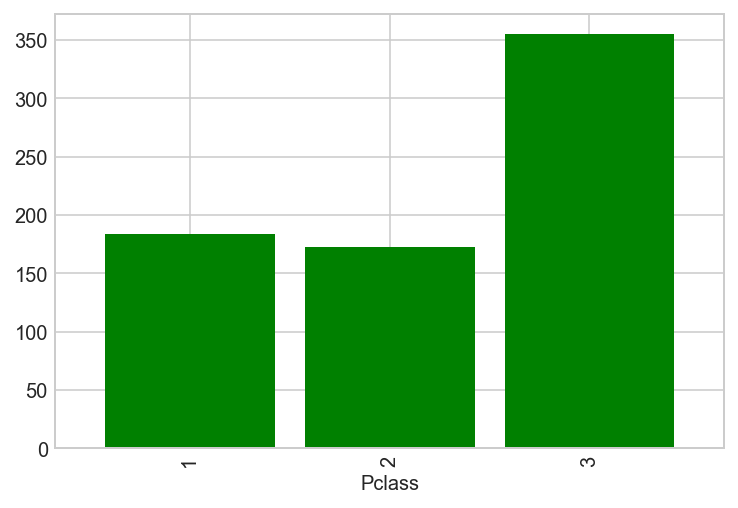

In [173]:
titanic.groupby('Pclass').size().plot(kind='bar',color='g',width=0.85)
plt.show()

**Plot the average fare per sex and class as a bar chart.**

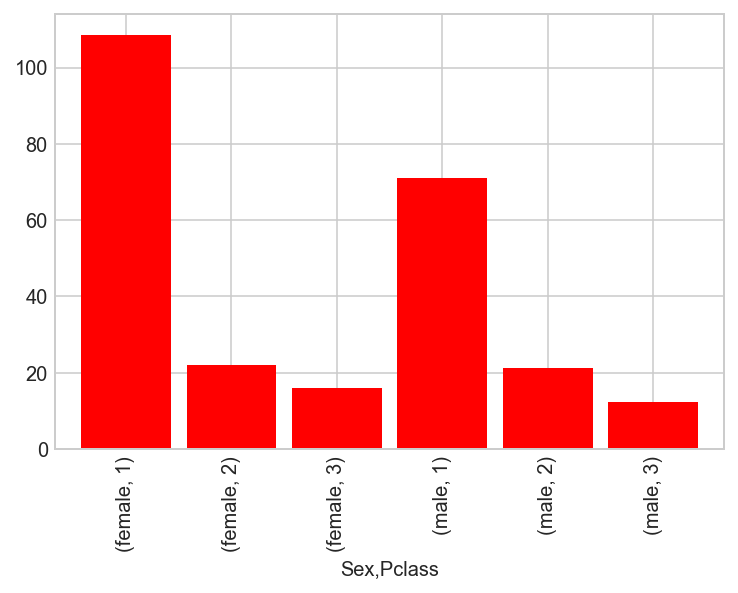

In [79]:
titanic.groupby(['Sex','Pclass'])['Fare'].mean().plot(kind='bar',color='r',width=0.85);

<a id='grouped_hists'></a>

### Grouped bar charts with pandas

---

In the chart we just made, each bar represents a distinct combination of our groups in the `.groupby`. This is fine, but it would be a more visually appealing and informative chart if we had one of the groups as different colors and could make a grouped bar chart.

**Calculate the mean of Fare by Pclass and Sex using `groupby`, assign it to a variable, and print it out.**

In [62]:
fare_mean=titanic.groupby(['Pclass','Sex'])[['Fare']].mean()

In [63]:
fare_mean

Fare
Pclass Sex               
1      female  108.619680
       male     71.142781
2      female   21.951070
       male     21.113131
3      female   15.875369
       male     12.162695

There is another built-in function for pandas objects called `.unstack()`. When we have a hierarchical index like we do above with Pclass as the broader category and Sex as the sub-category, the `.unstack()` command will attempt to move the subcategory from an index to column representation.

This is a way to move from a "long" to "wide" column format.

**Use the `.unstack()` function on your mean fare variable.**

In [64]:
fare_mean.unstack()

Fare           
Sex         female       male
Pclass                       
1       108.619680  71.142781
2        21.951070  21.113131
3        15.875369  12.162695

**Now use the plot function on the unstacked data to create a bar chart.**

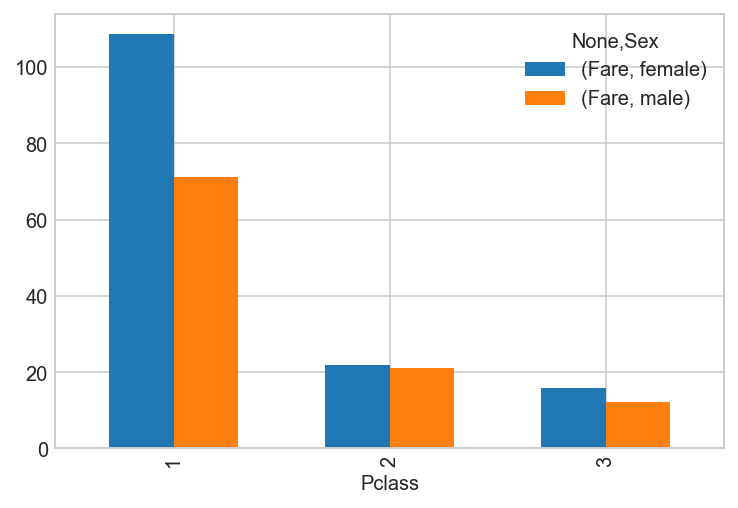

In [80]:
fare_mean.unstack().plot(kind='bar',width=0.6);

If you add the keyword variable `stacked=True` it will instead stack the bars within the broader Pclass category.

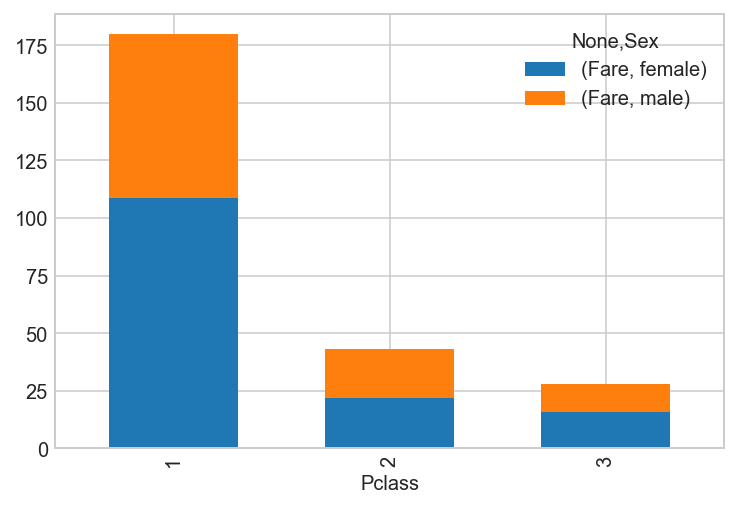

In [81]:
fare_mean.unstack().plot(kind='bar',width=0.6,stacked=True);

### Using .agg( ) 

---

You can use `.agg()` on a groupby object to get different functions for different columns.

You want to create a dictionary with key-value pairs that look like `column_name:[list of functions]`

Many functions are built into Pandas and can be accessed by a string.

You can also put in lambda functions or functions that you've defined elsewhere!

OR, instead of passing `.agg()` a dictionary, you can just pass it a list instead, in which case it will perform every function in that list for each column you've included in the groupby output.

In [82]:
def money_conversion_mean(x): #convert according to made-up conversion, then find mean
    converted = x/12 * 5 
    return np.mean(converted)

titanic.groupby('Pclass').agg({'Survived':'mean',
                               'Age':['mean','median','count','std'],
                               'SibSp':lambda x: np.mean(x),
                               'Fare':['mean',money_conversion_mean]})

Survived        Age                             SibSp       Fare  \
            mean       mean median count        std  <lambda>       mean   
Pclass                                                                     
1       0.652174  38.105543   37.0   184  14.778904  0.456522  88.048121   
2       0.479769  29.877630   29.0   173  14.001077  0.427746  21.471556   
3       0.239437  25.140620   24.0   355  12.495398  0.585915  13.229435   

                              
       money_conversion_mean  
Pclass                        
1                  36.686717  
2                   8.946482  
3                   5.512265

In [83]:
titanic.groupby(['Sex','Pclass'])[['Survived','Age','Fare']].agg(['mean','median','std'])

Survived                         Age                    \
                   mean median       std       mean median        std   
Sex    Pclass                                                           
female 1       0.963855      1  0.187784  34.240964   35.0  13.430572   
       2       0.918919      1  0.274823  28.722973   28.0  12.872702   
       3       0.460784      0  0.500921  21.750000   21.5  12.729964   
male   1       0.396040      0  0.491512  41.281386   40.0  15.139570   
       2       0.151515      0  0.360375  30.740707   30.0  14.793894   
       3       0.150198      0  0.357973  26.507589   25.0  12.159514   

                     Fare                       
                     mean    median        std  
Sex    Pclass                                   
female 1       108.619680  83.15830  77.968328  
       2        21.951070  22.00000  10.906269  
       3        15.875369  12.94585   9.358306  
male   1        71.142781  52.00000  80.430599  
       2        21.113131  13.00000  14.707829  
       3        12.162695   7.92500  10.129882

<a id='independent_practice'></a>

### Independent practice with grouping

---

Now that you've covered the basics of grouping, applying functions and aggregating data, and pandas plotting with grouped data, [open up the practice notebook and explore the UFO sightings data!](./practice-pandas-grouping.ipynb)